In [2]:
import numpy as np
import pandas as pd
import pickle
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

sns.set_style('whitegrid')
# sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import scale
from sklearn.model_selection import ShuffleSplit
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
# pgmpy 
from pgmpy.readwrite.XMLBeliefNetwork import XBNWriter
from pgmpy.readwrite import PomdpXWriter
from pgmpy.readwrite import XMLBIFWriter,XMLBIFReader,XBNReader
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch,HillClimbSearch, BicScore,BDeuScore
from pgmpy.estimators import K2Score,TreeSearch,BayesianEstimator ,ParameterEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator,ExpectationMaximization


from pgmpy.estimators import MmhcEstimator #hybrid method
import networkx as nx
from ivpy import discretize

### Helper functions

In [3]:
def roc_auc2(data=[], plot=True):
    from sklearn.metrics import roc_curve, roc_auc_score
    count = 1
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10,10))
    for d in data:
        model_name =d[0]
        Y_test= d[1]
        probs = d[2]
        _auc = roc_auc_score(Y_test, probs)
#         print(f'{model_name}: AUROC = %0.3f'%_auc)
        #Calculate ROC curve
        _fpr, _tpr, _ = roc_curve(Y_test, probs)
        
        tprs.append(np.interp(mean_fpr, _fpr, _tpr))
        tprs[-1][0] = 0.0

        aucs.append(_auc)
    
        plt.plot(_fpr, _tpr, lw=2, alpha=0.5,
                 label='ROC Study day %d (AUC = %0.2f)' % (model_name, _auc))
            # Show plot
        count += 1
        
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    
    
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title(f'Study days, {name}',fontsize=18)
    plt.legend(loc="lower right", prop={'size': 17})
    plt.savefig(r'figures/model_auc/{}.png'.format(model_name))
    plt.show()
#     print(confusion_matrix(Y_test,probs))
    return _auc
def read_data(path="day0_discrete_filtered_features.csv",day=-1 , sep=","):
    #read data
    df = pd.read_csv(path,sep)
    if day>=0:
        prop = (df.day==day)
        df=df[prop]
    return df
    
def get_details(features=[]):
    fd=read_data(path='desc.txt', sep=',')
    return fd[fd["Feature"].isin(features)]

def get_definitions(df,feature:str)->str:
    return df[df["Feature"]==feature]["Definition"]

def prob(A):
    """Computes the probability of a proposition, A."""    
    return A.mean()

def conditional(proposition, given):
    """Probability of A conditioned on given."""
    return prob(proposition[given])

def drop_high_corrs(df,t=0.9):
    # Create correlation matrix
    corr_matrix = df.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than t=0.95
    to_drop = [column for column in upper.columns if any(upper[column] >t )]
    # Drop features 
    return df.drop(df[to_drop], axis=1)

def is_independent(X, Y, Zs=[], significance_level=0.05):
    return est.test_conditional_independence(X, Y, Zs)[1] >= significance_level

def discretize_data(df, column_name:str, label:str, max_bin=9, min_result=26):
    res = discretize(df[column_name], df[label], maxbin=max_bin, minres=min_result)
    return res['breaks'],pd.cut(df[column_name],res['breaks'])

def get_f1_score(estimated_model, true_model):
    nodes = estimated_model.nodes()
    est_adj = nx.to_numpy_matrix(estimated_model.to_undirected(), nodelist=nodes, weight=None)
    true_adj = nx.to_numpy_matrix(true_model.to_undirected(), nodelist=nodes, weight=None)

    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))
    print("F1-score for the model skeleton: ", f1)
    
def roc_auc(data=[], plot=True):
    from sklearn.metrics import roc_curve, roc_auc_score
    count = 1
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10,10))
    for d in data:
        model_name =d[0]
        Y_test= d[1]
        probs = d[2]
        _auc = roc_auc_score(Y_test, probs)
#         print(f'{model_name}: AUROC = %0.3f'%_auc)
        #Calculate ROC curve
        _fpr, _tpr, _ = roc_curve(Y_test, probs)
        
        tprs.append(np.interp(mean_fpr, _fpr, _tpr))
        tprs[-1][0] = 0.0

        aucs.append(_auc)
    
        plt.plot(_fpr, _tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (count, _auc))
            # Show plot
        count += 1
        
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    
    
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title(f'Cross-Validation ROC of {model_name}',fontsize=18)
    plt.legend(loc="lower right", prop={'size': 15})
#     plt.savefig(r'figures/model_auc/{}.png'.format(model_name))
    plt.show()
#     print(confusion_matrix(Y_test,probs))
    return _auc


def select_features(df,class_label,n=20)->pd.DataFrame:
    from sklearn import preprocessing
    from collections import defaultdict
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import chi2
    try:
        del df["id"]
        del df["day"]
        del df["final_audit_final_dx"]
    except:
        pass
    d = defaultdict(preprocessing.LabelEncoder)
    df = data.apply(lambda x: d[x.name].fit_transform(x))
    y=df[class_label]
    X = df[[f for f in df.columns if f != class_label]]

    # apply SelectKBest class to extract top 10 best features
    best_features = SelectKBest(score_func=chi2, k=10)
    fit = best_features.fit(X,y)
    df_scores = pd.DataFrame(fit.scores_)
    df_columns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    feature_scores = pd.concat([df_columns,df_scores],axis=1)
    feature_scores.columns = ['Features','Score']  #naming the dataframe columns
#     print(feature_scores[feature_scores['Features'].isin(FEATURES)].sort_values(by='Score',ascending=False))
#     print(feature_scores.sort_values(by=["Score"],ascending=False).head(50))
    return(feature_scores.nlargest(n,'Score'))

def check_continues_features(df):
    df=df.copy()
    cl = []
    for i in df.columns:
        num = df[i].nunique()
#         print(i, type(num))
        if num >=4 and i!= "id":
#             print("\nColumn Name:",i,"-->",df[i].unique(),"-->Unique Count",len(df[i].unique()),"\n")
            cl.append(i)
    return cl

### Functions for applying the bins according to the DAIDS Documentation

In [3]:
def age(x):
    
    """
    Grade 0 = x>12
    Grade 1 = x<=7
    Grade 2 = x<=12
    """
    if x <=7:
        return 1
    elif x <= 12:
        return 2
    elif x >12:
        return 0


def ast_alt(x):
    
    """
    unit = (IU/L)
    Normal <=50  
    Grade 1 50 -99
    Grade 2 100-199
    Grade 3 200-399
    Grade 4 400-inf
    """
    if x <=50:
        return 0
    elif x <= 99:
        return 1
    elif x <= 199:
        return 2
    elif x <=399:
        return 3
    elif x >=400:
        return 4

def temprature(x):
    
    """
    Normal <=37.9
    Grade 1 38.0 to < 38.6°C
    Grade 2 ≥ 38.6  to < 39.3°C
    Grade 3 ≥ 39.3 to < 40.0°C 
    Grade 4 ≥ 40.0°C 
    """
    if x <=37.9:
        return 0
    elif x <= 38.5:
        return 1
    elif x <= 39.2:
        return 2
    elif x <=39.9:
        return 3
    elif x >=40.:
        return 4

def pmn(x):
    
    """
    PMN (Netrophils count) (cells/mm^3) X 1000
    Normal >1000
    Grade 1 800-1000
    Grade 2 600-799
    Grade 3 400-599
    Grade 4 400-inf
    """
    x=x*100
    if x >1000:
        return 0
    elif x <= 1000:
        return 1
    elif x <= 799:
        return 2
    elif x <=599:
        return 3
    elif x <400:
        return 4
    
def platelets(x):
    """
    unit = (ULN)
    Normal < 1.25
    Grade 1 1.25  to < 2.5 
    Grade 2 2.5  to < 5.0 
    Grade 3 5.0  to < 10.0
    Grade 4 ≥ 10.0
    """
    x = x * 1000
    if x >= 125000:
        return 0
    elif x < 125000:
        return 1
    elif x < 100000:
        return 2
    elif x < 50000:
        return 3
    elif x < 25000:
        return 4
    
def lymphocyte(x):
    """
    Lymphocyte count (cell/mm^3) *1000
    Normal >= 650
    Grade 1 600 to 650 
    Grade 2 500 to 600 
    Grade 3 350 to 500
    Grade 4 < 350
    """
#     x = x*
    if x >=650:
        return 0
    elif x > 599:
        return 1
    elif x > 499:
        return 2
    elif x > 349:
        return 3
    elif x < 349:
        return 4

### This function returns the model for the study day with the selected features 

In [34]:
def get_model(day=1):
    
    
    if day==1:
        best_model = [
                     ('dhf_dx', 'd04_diarrhea'),
                     ('dhf_dx', 'd04_abdominal'),
                     ('dhf_dx', 'd04_itching'),
                     ('dhf_dx', 'd05_atyp'),
                     ('dhf_dx', 'd04_injected'),
                     ('dhf_dx', 'd01_myalgia_day'),
                     ('dhf_dx', 'd05_band'),
                     ('dhf_dx', 'd03_intake_diff'),
                     ('dhf_dx', 'd04_clear'),
                     ('dhf_dx', 'd05_eosin'),
                     ('dhf_dx', 'd03_pulse_rate_avg'),
                     ('dhf_dx', 'd03_hct_max'),
                     ('dhf_dx', 'd05_lymp'),
                     ('dhf_dx', 'd05_pmn'),
                     ('dhf_dx', 'd03_temp_min'),
                     ('dhf_dx', 'd05_lft_protein'),
                     ('dhf_dx', 'd05_ast_alt'),
                     ('dhf_dx', 'd05_sgot_platelet_ratio'),
                     ('dhf_dx', 'd04_ab_circum'),
                     ("dhf_dx","fever_day"),
                     ('fever_day', 'd05_sgot_platelet_ratio'),
                     ('fever_day', 'd04_abdominal'),
                     ('fever_day', 'd04_injected'),
                     ('fever_day','d04_itching'),
                    ]
    if day==2:
        best_model = [('dhf_dx', 'd03_temp_min_2'),
                     ('dhf_dx', 'd04_ab_circum_1'),
                     ('dhf_dx', 'd05_lymp_2'),
                     ('dhf_dx', 'd03_hct_avg_d'),
                     ('dhf_dx', 'd05_lft_ast_1'),
                     ('dhf_dx', 'd05_lft_alt_1'),
                     ('dhf_dx', 'd05_lft_protein_d'),
                     ('dhf_dx', 'd05_lymp_d'),
                     ('dhf_dx', 'd05_lymp_1'),
                     ('dhf_dx', 'd03_temp_min_1'),
                     ('dhf_dx', 'd04_clear_1'),
                     ('dhf_dx', 'd05_lft_protein_2'),
                     ('dhf_dx', 'd03_pulse_rate_range_2'),
                     ('dhf_dx', 'd05_band_1'),
                     ('dhf_dx', 'd05_pmn_d'),
                     ('dhf_dx', 'd05_pmn_2'),
                     ('dhf_dx', 'd04_abdominal_2'),
                     ('dhf_dx', 'd05_atyp_2'),
                     ('dhf_dx', 'd03_hct_avg_2'),
                     ('dhf_dx', 'd04_injected_2'),
                     ('dhf_dx', 'd03_intake_diff_1'),
                     ('dhf_dx', 'd05_ast_alt_1'),
                     ('dhf_dx', 'd04_ab_circum_d'),
                     ('dhf_dx', 'd03_intake_diff_d'),
                     ('dhf_dx', 'd03_intake_diff_2'),
                     ('dhf_dx', 'd04_diarrhea_1'),
                     ('dhf_dx', 'd03_temp_min_d'),
                    #  ('dhf_dx', 'fever_day'),
                     ('dhf_dx', 'd03_pulse_rate_range_1'),
                     ('dhf_dx', 'd05_pmn_1'),
                    #  ('dhf_dx', 'd04_itching_2'),
                     ('dhf_dx', 'd05_lft_protein_1'),
                     ('dhf_dx', 'd05_eosin_1'),
                     ('dhf_dx', 'd05_eosin_2'),
                     ('dhf_dx', 'd04_abdominal_1'),
                     ('dhf_dx', 'd05_lft_alt_d'),
                     ('dhf_dx', 'd03_pulse_pre_min_2'),
                     ('dhf_dx', 'd03_pulse_pre_min_d'),
                     ('dhf_dx', 'd03_pulse_pre_min_1'),
                    #  ('dhf_dx', 'd04_injected_1'),
                     ('fever_day', 'd05_ast_alt_d'),
                     ('fever_day', 'd05_pmn_d'),
                     ('fever_day', 'd05_lft_ast_1'),
                     ('fever_day', 'd03_hct_avg_2'),
                     ('fever_day', 'd05_lft_protein_d'),
                    #  ('fever_day', 'd05_eosin_1'),
                     ('fever_day', 'd04_abdominal_1'),
                     ('fever_day', 'd04_abdominal_2'),
                     ('fever_day', 'd05_pmn_2'),
                     ('fever_day', 'd04_injected_1')]
    if day==3:
            best_model = [
                ('dhf_dx', 'd04_ab_circum_2'),
             ('dhf_dx', 'd05_eosin_2'),
             ('dhf_dx', 'd03_pulse_pre_min_3'),
             ('dhf_dx', 'd03_intake_diff_1'),
             ('dhf_dx', 'd03_hct_avg_3'),
             ('dhf_dx', 'd05_lft_protein_1'),
             ('dhf_dx', 'd05_pmn_2'),
             ('dhf_dx', 'd03_hct_avg_d'),
             ('dhf_dx', 'd05_lft_protein_d'),
             ('dhf_dx', 'd05_ast_alt_d'),
             ('dhf_dx', 'd03_temp_min_d'),
             ('dhf_dx', 'd05_pmn_1'),
             ('dhf_dx', 'd05_lymp_3'),
             ('dhf_dx', 'd05_band_2'),
             ('dhf_dx', 'd05_lft_protein_3'),
             ('dhf_dx', 'd04_abdominal_2'),
             ('dhf_dx', 'd04_abdominal_3'),
             ('dhf_dx', 'fever_day'),
             ('dhf_dx', 'd03_pulse_rate_range_2'),
             ('dhf_dx', 'd04_abdominal_d'),
             ('dhf_dx', 'd05_atyp_2'),
             ('dhf_dx', 'd05_ast_alt_3'),
             ('dhf_dx', 'd03_intake_diff_2'),
             ('dhf_dx', 'd05_eosin_3'),
             ('dhf_dx', 'd05_band_1'),
             ('dhf_dx', 'd04_injected_1'),
             ('dhf_dx', 'd04_itching_2'),
             ('dhf_dx', 'd03_temp_min_1'),
             ('dhf_dx', 'd04_clear_1'),
             ('dhf_dx', 'd05_pmn_3'),
             ('dhf_dx', 'd03_pulse_pre_min_1'),
             ('dhf_dx', 'd04_diarrhea_3'),
             ('dhf_dx', 'd04_injected_2'),
             ('dhf_dx', 'd05_lft_alt_1'),
             ('dhf_dx', 'd04_injected_3'),
             ('dhf_dx', 'd04_ab_circum_1'),
             ('dhf_dx', 'd04_diarrhea_1'),
             ('dhf_dx', 'd03_intake_diff_3'),
             ('dhf_dx', 'd05_lft_protein_2'),
             ('dhf_dx', 'd05_lymp_2'),
             ('dhf_dx', 'd05_lymp_d'),
             ('dhf_dx', 'd04_ab_circum_d'),
             ('dhf_dx', 'd03_pulse_rate_range_1'),
             ('dhf_dx', 'd03_hct_avg_2'),
             ('dhf_dx', 'd05_ast_alt_2'),
             ('dhf_dx', 'd05_lft_alt_d'),
             ('dhf_dx', 'd03_temp_min_3'),
             ('fever_day', 'd05_lft_protein_3'),
             ('fever_day', 'd05_lft_ast_1'),
             ('fever_day', 'd05_ast_alt_2'),
             ('fever_day', 'd05_pmn_2'),
             ('fever_day', 'd03_hct_avg_3'),
             ('fever_day', 'd05_atyp_2'),
             ('fever_day', 'd05_band_3'),
             ('fever_day', 'd04_diarrhea_3'),
             ('fever_day', 'd03_pulse_rate_range_1'),
             ('fever_day', 'd05_eosin_2'),
             ('fever_day', 'd04_injected_1'),
             ('fever_day', 'd04_injected_3'),
             ('fever_day', 'd04_ab_circum_1')
            ]
    model = BayesianModel(best_model)
    return model

### This function read the data from disk and discretize them

In [35]:
def get_data(day=1,disc=True):
    if day==1:
        data = read_data("../Data/data_final - Ordered.csv",day=-1)
        d = data[data['day0_in']<=0]
#         d = preprocessing.normalize(d)
        
        data = d.drop_duplicates(subset=['id'],keep='first')
        data["d05_ast_alt"] = data['d05_lft_ast'] / data['d05_lft_alt']
#         data["d03_hct_avg"] =  data['d03_hct_max']
#         data['d03_pulse_rate_range'] = data["d03_pulse_rate_max"]
#         data['d05_pmn']=data['d05_pmn'].apply(lambda X: pmn(X))
#         data['d05_platelet']=data['d05_platelet'].apply(lambda X: platelets(X))
#         data['d03_temp_min']=data['d03_temp_min'].apply(lambda X: temprature(X))
#         data['d05_lft_ast']=data['d05_lft_ast'].apply(lambda X: ast_alt(X))
#         data['d05_lft_alt']=data['d05_lft_alt'].apply(lambda X: ast_alt(X))
#         data['d05_lymp']=data['d05_lymp'].apply(lambda X: lymphocyte(X))
        data = data.reset_index(drop=True)
        bins ={}
        
    if day==2:
        data = read_data("data_for_day2 - Ordered.csv",day=-1)
        d = data[data['day0_in']<=0]
        data = d.drop_duplicates(subset=['id'],keep='first')
        data["d05_ast_alt_1"] = data['d05_lft_ast_1'] / data['d05_lft_alt_1']
        data["d05_ast_alt_2"] = data['d05_lft_ast_2'] / data['d05_lft_alt_2']
        data["d05_ast_alt_d"] = data['d05_lft_ast_2'] - data['d05_lft_alt_1']
#         data['d05_pmn_1']=data['d05_pmn_1'].apply(lambda X: pmn(X))
#         data['d05_platelet_1']=data['d05_platelet_1'].apply(lambda X: platelets(X))
#         data['d03_temp_min_1']=data['d03_temp_min_1'].apply(lambda X: temprature(X))
#         data['d05_lft_ast_1']=data['d05_lft_ast_1'].apply(lambda X: ast_alt(X))
#         data['d05_lft_alt_1']=data['d05_lft_alt_1'].apply(lambda X: ast_alt(X))
#         data['d05_lymp_1']=data['d05_lymp_1'].apply(lambda X: lymphocyte(X))
#         data['d05_pmn_2']=data['d05_pmn_2'].apply(lambda X: pmn(X))
#         data['d05_platelet_2']=data['d05_platelet_2'].apply(lambda X: platelets(X))
#         data['d03_temp_min_2']=data['d03_temp_min_2'].apply(lambda X: temprature(X))
#         data['d05_lft_ast_2']=data['d05_lft_ast_2'].apply(lambda X: ast_alt(X))
#         data['d05_lft_alt_2']=data['d05_lft_alt_2'].apply(lambda X: ast_alt(X))
#         data['d05_lymp_2']=data['d05_lymp_2'].apply(lambda X: lymphocyte(X))
        
    if day==3:
        data = read_data("data_for_day3 - Ordered.csv",day=-1)
        d = data[data['day0_in']<=0]
        data = d.drop_duplicates(subset=['id'],keep='first')
        data = data.reset_index(drop=True)
        data["d05_ast_alt_1"] = data['d05_lft_ast_1'] / data['d05_lft_alt_1']
        data["d05_ast_alt_2"] = data['d05_lft_ast_2'] / data['d05_lft_alt_2']
        data["d05_ast_alt_3"] = data['d05_lft_ast_3'] / data['d05_lft_alt_3']
        data["d05_ast_alt_m"] = (data['d05_ast_alt_3']+ data['d05_ast_alt_2'] + data['d05_ast_alt_1'])/3
        data["d05_ast_alt_d"] = data['d05_lft_ast_2'] - data['d05_lft_ast_3'] - data['d05_lft_alt_1']
        data["d05_lft_alt_d"] = data['d05_lft_alt_3']- data['d05_lft_alt_2'] - data['d05_lft_alt_1']
        data["d04_abdominal_d"] = data['d04_abdominal_3']- data['d04_abdominal_2'] - data['d04_abdominal_1']
        data["d05_lymp_d"] = data['d05_lymp_3']- data['d05_lymp_2'] - data['d05_lymp_1']
        data["d03_hct_avg_d"] = data['d03_hct_avg_3']- data['d03_hct_avg_2'] - data['d03_hct_avg_1']
        data["d05_lft_protein_d"] = data['d05_lft_protein_3']- data['d05_lft_protein_2'] - data['d05_lft_protein_1']
        data["d04_ab_circum_d"] = data['d04_ab_circum_3']- data['d04_ab_circum_2'] - data['d04_ab_circum_1']
        data["d03_pulse_pre_min_d"] = data['d03_pulse_pre_min_3']- data['d03_pulse_pre_min_2'] - data['d03_pulse_pre_min_1']
        data["d04_ab_circum_m"] = (data['d04_ab_circum_3']+ data['d04_ab_circum_2'] + data['d04_ab_circum_1'])/3
        data["d03_temp_min_d"] = data['d03_temp_min_3']- data['d03_temp_min_2'] - data['d03_temp_min_1']
        data["d03_temp_min_m"] = (data['d03_temp_min_3']+ data['d03_temp_min_2'] + data['d03_temp_min_1'])/3
        data["d03_pulse_pre_min_m"] = (data['d03_pulse_pre_min_3']+ data['d03_pulse_pre_min_2'] + data['d03_pulse_pre_min_1'])/3
        data["d05_ast_alt_1"] = data['d05_lft_ast_1'] / data['d05_lft_alt_1']
        data["d05_ast_alt_2"] = data['d05_lft_ast_2'] / data['d05_lft_alt_2']
        data["d05_ast_alt_d"] = data['d05_lft_ast_2'] - data['d05_lft_alt_1']
        data["d03_hct_avg_3"] = (data["d03_hct_max_1"]+data["d03_hct_max_3"])/2
        data["d03_hct_avg_d"] = data["d03_hct_max_3"]-data["d03_hct_max_1"]
#         data['d05_pmn_1']=data['d05_pmn_1'].apply(lambda X: pmn(X))
#         data['d05_platelet_1']=data['d05_platelet_1'].apply(lambda X: platelets(X))
#         data['d03_temp_min_1']=data['d03_temp_min_1'].apply(lambda X: temprature(X))
#         data['d05_lft_ast_1']=data['d05_lft_ast_1'].apply(lambda X: ast_alt(X))
#         data['d05_lft_alt_1']=data['d05_lft_alt_1'].apply(lambda X: ast_alt(X))
#         data['d05_lymp_1']=data['d05_lymp_1'].apply(lambda X: lymphocyte(X))
#         data['d05_pmn_2']=data['d05_pmn_2'].apply(lambda X: pmn(X))
#         data['d05_platelet_2']=data['d05_platelet_2'].apply(lambda X: platelets(X))
#         data['d03_temp_min_2']=data['d03_temp_min_2'].apply(lambda X: temprature(X))
#         data['d05_lft_ast_2']=data['d05_lft_ast_2'].apply(lambda X: ast_alt(X))
#         data['d05_lft_alt_2']=data['d05_lft_alt_2'].apply(lambda X: ast_alt(X))
#         data['d05_lymp_2']=data['d05_lymp_2'].apply(lambda X: lymphocyte(X))
#         data['d05_pmn_3']=data['d05_pmn_3'].apply(lambda X: pmn(X))
#         data['d05_platelet_3']=data['d05_platelet_3'].apply(lambda X: platelets(X))
#         data['d03_temp_min_3']=data['d03_temp_min_3'].apply(lambda X: temprature(X))
#         data['d05_lft_ast_3']=data['d05_lft_ast_3'].apply(lambda X: ast_alt(X))
#         data['d05_lft_alt_3']=data['d05_lft_alt_3'].apply(lambda X: ast_alt(X))
#         data['d05_lymp_3']=data['d05_lymp_3'].apply(lambda X: lymphocyte(X))

    if disc:
        bins={}
        for c in check_continues_features(data):
            b,d=discretize_data(data,c,"dhf_dx")
            bins[c]=b
            data[c] = d
            
    return data

In [ ]:
def checkmodel(f=["age","d01_sex"]):
    infer = VariableElimination(model)
    target= "dhf_dx"
    x_test2=x_test[f]
    result=[]
    for c,r in x_test2.iterrows():
        ev = r.to_dict()
        re = infer.query(variables=[target],evidence=ev).values
        result.append(re[1])
    return np.array(result)

model_obj = {}
for day in range(1,2):

    # evidenced:

    name= f"study day {day}"
    data = get_data(day)
    model=get_model(day)
    # cross validation:
    rs = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
    ev_f = [i for i in model.nodes() if not i=="dhf_dx"]
    ev_f = [i for i in ev_f if  "pulse_rate_range" not in i]
#     ev_f = [i for i in ev_f  if not((i.startswith("d05_")) and (i.endswith("_d")))] 
#     ev_f = [i for i in ev_f if not((i.startswith("d05_")) and (i.endswith("_2")))]
#     ev_f = [i for i in ev_f if not((i.startswith("d05_")) and (i.endswith("_3")))]
    
    ev_f = [i for i in ev_f if  "intake_diff" not in i]
    
#     ev_f = [i for i in ev_f if not i=="d03_pulse_rate_range_3"]
#     ev_f = [i for i in ev_f if not i=="d03_intake_diff_2"]
#     ev_f = [i for i in ev_f if not i=="d03_intake_diff_3"]
    ev_f = [i for i in ev_f if not i.endswith("_2")]
    
#     ev_f = [i for i in ev_f if not i.startswith("d03_hct_")]
#     ev_f = [i for i in ev_f if not i.startswith("d05_")]
    print(ev_f)
    print(len(ev_f))
    
    
    i=0
    aucs=[]
    trs=[]
    preds = []

    for train_index, test_index in rs.split(data):
        X_train=data.iloc[train_index]
        X_test=data.iloc[test_index]
        x_test = X_test[[f for f in X_test.columns if f != "dhf_dx"]]
        y_test =  np.array(X_test[["dhf_dx"]].values)
        print(len(x_test),len(X_train))
        

    #     training:
        model.fit(X_train, estimator=BayesianEstimator)
        res = checkmodel(ev_f)
    #     print(metrics.accuracy_score(y_test,classifier.predict(X_test)))
    
    # besat thresholds
    
        fpr, tpr, thresholds = metrics.roc_curve(y_test, res)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        trs.append(optimal_threshold)
        preds.append({"test":y_test,"pred":res})
#         print(confusion_matrix(y_test, res))

        #evaluation
        model_name = f'{name}-{i}'
        
        # write the model on disk
#         writer = XMLBIFWriter(model)
#         writer.write_xmlbif(f'models/{model_name}.xml')
        # writer = XBNWriter(model = model)
        t = [[name+'_'+str(i),y_test,res]]
        # r.append(t)
        auc=roc_auc(t)
        model_obj[model_name]={}
        model_obj[model_name]["auc"]=auc
        model_obj[model_name]["y_test"]=y_test
        model_obj[model_name]["res"]=res
        model_obj[model_name]["name"]=name

        aucs.append(auc)
        i+=1

        models.append(model_obj)
        # with open('models/day_model.pickle', 'wb') as handle:
        #     pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [45]:
a = np.where(preds[0]["pred"]>0.56,1,0)
print("confusion matrix for study day 1")
print(confusion_matrix(preds[0]['test'],a))

confusion matrix for study day 1
[[190  38]
 [ 70 136]]


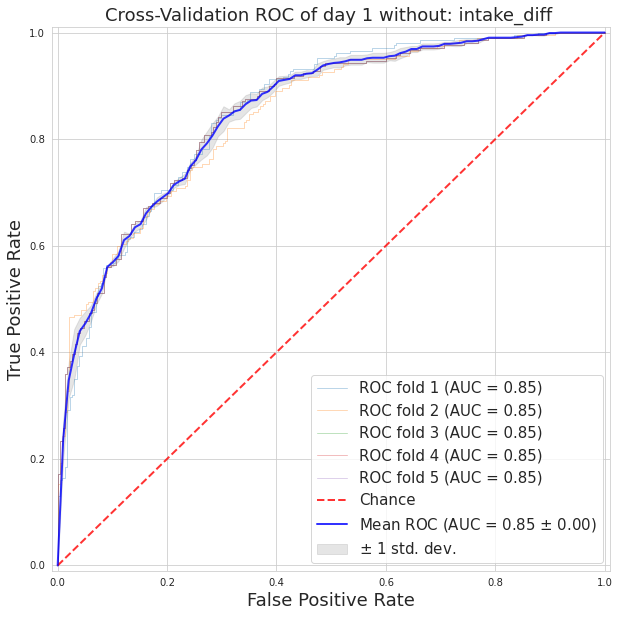

0.8526315789473684

In [47]:
t_plot=[]
models = [model_obj]
name = "model-day 1",
mixed ='study day 1-0'
base = 'study day 1-1' 
plos=  'study day 1-2'
plos2 = 'study day 1-3'
plos3 = 'study day 1-4'






t_plot.append([
    1,
    models[0][mixed]['y_test'],
    models[0][mixed]['res'],
])
t_plot.append([
    2,
    models[0][base]['y_test'],
    models[0][base]['res'],
])
t_plot.append([
    3,
    models[0][plos]['y_test'],
    models[0][plos]['res'],
])
t_plot.append([
    3,
    models[0][plos]['y_test'],
    models[0][plos]['res'],
])
t_plot.append([
    'day 1 without: intake_diff ',
    models[0][plos]['y_test'],
    models[0][plos]['res'],
])
roc_auc(t_plot)

In [48]:
infer = VariableElimination(model)
target= "dhf_dx"
print(infer.query(variables=[target,"fever_day"],joint=True))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------+------------------------+-------------------------+
| dhf_dx    | fever_day              |   phi(dhf_dx,fever_day) |
+===========+========================+=========================+
| dhf_dx(0) | fever_day((-inf, 1.5]) |                  0.0548 |
+-----------+------------------------+-------------------------+
| dhf_dx(0) | fever_day((1.5, 2.5])  |                  0.1008 |
+-----------+------------------------+-------------------------+
| dhf_dx(0) | fever_day((2.5, 3.5])  |                  0.1860 |
+-----------+------------------------+-------------------------+
| dhf_dx(0) | fever_day((3.5, 4.5])  |                  0.1492 |
+-----------+------------------------+-------------------------+
| dhf_dx(0) | fever_day((4.5, inf])  |                  0.0410 |
+-----------+------------------------+-------------------------+
| dhf_dx(1) | fever_day((-inf, 1.5]) |                  0.0426 |
+-----------+------------------------+-------------------------+
| dhf_dx(1) | fever_day((

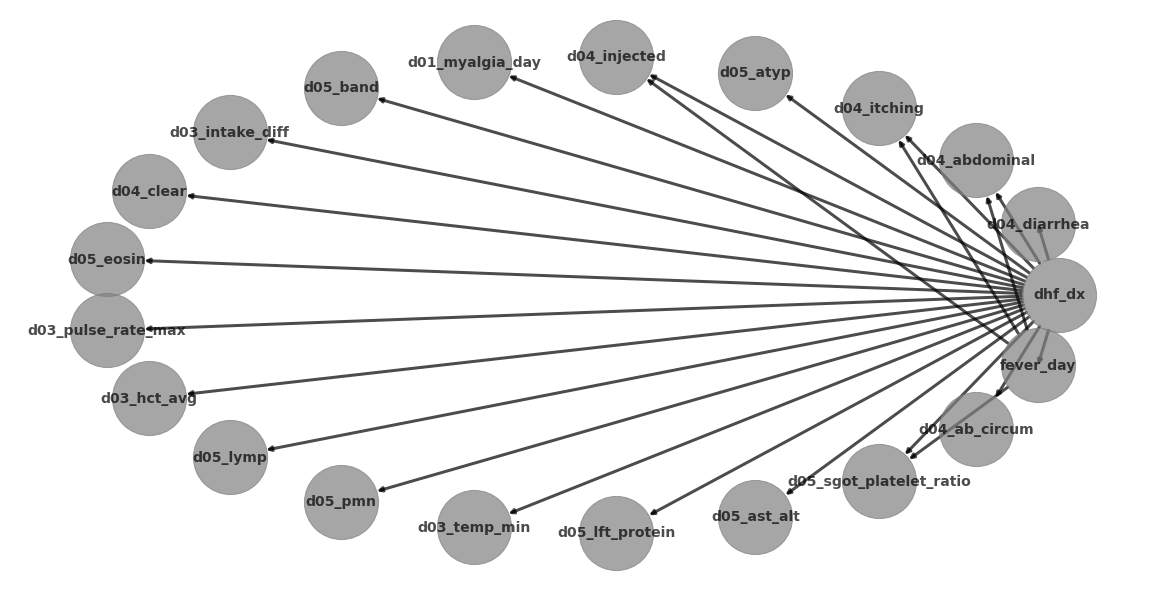

In [49]:

plt.figure(figsize=(16,8))
position = nx.layout.kamada_kawai_layout(model)
nx.draw(model,pos=position,with_labels=True,node_color='gray',
        node_size=5500,font_size=14,width=3,arrowsize=9,
       font_weight='bold',alpha=0.7)
# plt.savefig(f"models/{model_name}.png")
plt.show()

In [36]:
data = get_data(1)
for i in data.dtypes.keys():
    if data.dtypes[i]=='category':
        data[i]=data[i].cat.codes 
# data.to_csv("data_for_day1 -discret.csv")
features = list(get_model(1).nodes())
data = data[features]
print(f'shape of data: {data.shape}')


shape of data: (1733, 21)


['dhf_dx',
 'd04_diarrhea',
 'd04_abdominal',
 'd04_itching',
 'd05_atyp',
 'd04_injected',
 'd01_myalgia_day',
 'd05_band',
 'd03_intake_diff',
 'd04_clear',
 'd05_eosin',
 'd03_pulse_rate_avg',
 'd03_hct_max',
 'd05_lymp',
 'd05_pmn',
 'd03_temp_min',
 'd05_lft_protein',
 'd05_ast_alt',
 'd05_sgot_platelet_ratio',
 'd04_ab_circum',
 'fever_day']

mean of AUCs: 0.8389478344870767


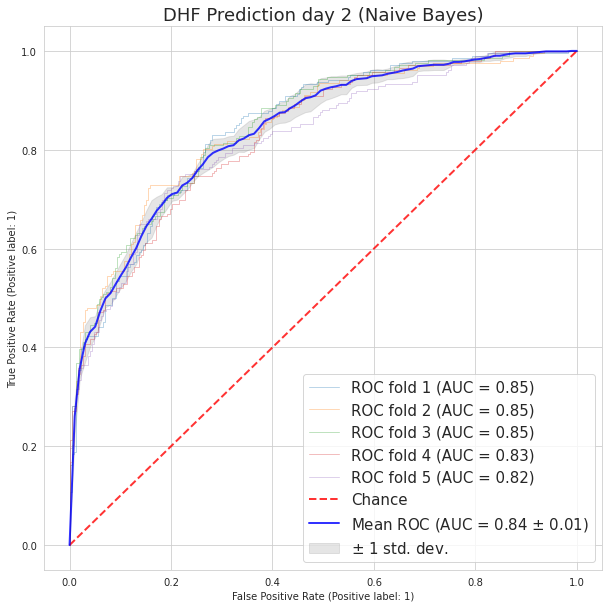

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import CategoricalNB, MultinomialNB, BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier,HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import auc,confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# #############################################################################
# Data IO and generation

# X = data.drop(['dhf_dx'],axis=1)
# y = data[['dhf_dx']]
# n_samples, n_features = X.shape

rs = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier = CategoricalNB()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,10))
i=1



for train_index, test_index in rs.split(data):
    X_train=data.iloc[train_index]
    y_train = X_train[["dhf_dx"]]
    X_train = X_train.drop(['dhf_dx'],axis=1)
    x_test= data.iloc[test_index]
    y_test = np.array(x_test[["dhf_dx"]].values)
    X_test = x_test.drop(["dhf_dx"],axis=1)
#     print(f"number of training set: {len(X_train)}, number of test {len(y_test)} ")
#     scaler = MinMaxScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
#     p = Pipeline([('Normalizing',MinMaxScaler()),('bn',classifier)])
    classifier.fit(X_train,y_train )
    y_pred = classifier.predict(X_test)#[:,1]
#     print(metrics.accuracy_score(y_test,classifier.predict(X_test)))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
#     print("Threshold value is:", optimal_threshold)
#     print(confusion_matrix(y_test, y_pred))
    
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    
    i+=1
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
print(f'mean of AUCs: {mean_auc}')

ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)


std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05]
    
)
plt.title(label="DHF Prediction day 2 (Naive Bayes)",fontsize=18)
ax.legend(loc="lower right", prop={'size': 15})
plt.show()